In [77]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf 
from IPython.core.interactiveshell import InteractiveShell
import warnings 
InteractiveShell.ast_node_interactive = "all"
warnings.filterwarnings("ignore")

2022-03-28 10:40:23.194700: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-28 10:40:23.194722: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Theory

Consider a system where:

\begin{equation}
h^t= f (h^{t-1},\theta)  
\end{equation}
\begin{equation}
\theta \text{: parameters shared across all time steps}
\end{equation}

That is, its state at time step t, is dependent only on a set a parameters and the previous state at t-1
<br>
<br>
Let the state of the system, h, also be depedent on an input at the respective time step, x:

\begin{equation}
h^t= f (h^{t-1},x^{t},\theta)  
\end{equation}

The state h now contains information about the entire past history of inputs, x.

Consider now a system that given the hidden state, h,produces an output o, for each time step. This output is passed to an activation function made to predict the target, y, at the respective time step.

\begin{equation}
o^t= g (h^{t},\theta')  
\end{equation}
\begin{equation}
\theta' \text{: a different set of parameters as $\theta$}
\end{equation}


We define now define $\theta$ and $\theta'$ as the weight matrices describing the relation between the input-to-hidden, hidden-to-hidden and hidden-to-output notes; $U$, $W$ and $V$:

\begin{equation}
z^t=  W^{T}h^{t-1} + U^{T}x^t +b 
\end{equation}

\begin{equation}
h^{t} = \phi(z^t)
\end{equation}

\begin{equation}
o^t = V^Th^{t} + c
\end{equation}

Where $b$ and $c$ are biases, $\phi$ is an activation function. <br><br>
**Note**: matrices $U$, $W$ and $V$ are not indexed by time. 

Then for each time step, we have a sequential total loss up to time step $\tau$, $L^\tau$, defined as the difference between our prediction and the target, at each output, upto the time step $\tau$
<br>
<br>
Consider the task of multi-class classification. 
<br>
<br>
Consequently, the output activation function is the normalized expontential function, a.k.a the _softmax function_

\begin{equation}
L = \sum_{t=1}^{\tau} l\big(o^{t}\big)
\text{: Total loss upto time step $\tau$}  
\end{equation}

\begin{equation}
\hat{y}^t_i = \frac{\exp(o_i^t)}{\sum_{j}\exp(o_j^t)}
\text{: Softmax activation function for multi-class classification}
\end{equation}

**NOTE** the softmax is a vector function, later when taking the derivative, in reality I am finding the Jacobian of it in its vector form, but here I denote one element of it, the $i^{th}$

\begin{equation}
l = - \sum_{m=0}^{M-1}y_{m}^{t} \log\Big(\hat{y}_{m}^{t}\Big)
\text{: M categorical cross entropy for predictions at time step $t$}
\end{equation}


The optimization process differs from standard back-propagation (like descirbed for a vanilla feedforward network). Usng the above assumptions, I will go through the derivation analogous optimization process for recurrent networks;

### Back propagation through time

Per example loss w.r.t to the output element $o_i$ at time $t$; $o_i^{t}$

\begin{equation}
\nabla_{o_{i}^{t}} L = \frac{\partial{L}}{\partial{l(o_i^t)}} \frac{\partial{l(o_i^t)}}{\partial o_{i}^{t}}
\end{equation}
Note that:
\begin{equation}
 \frac{\partial{L}}{\partial{l(o_i^t)}} = 1
\end{equation}
and that:
\begin{equation}
 \frac{\partial{l(o_i^t)}}{\partial o_{i}^{t}}
\end{equation}
is the derivative of the categorical cross-entropy
\begin{equation}
\boxed{
 \frac{\partial{l(o_i^t)}}{\partial o_{i}^{t}} = - \sum_{j} \frac{y_j^{t}}{\hat{y}_j^{t}}\frac{\partial{\hat{y}^{t}_j}}{\partial{o_i^{t}}} } - [1]
\end{equation}
The softmax functions is:
 \begin{equation}
 \hat{y}^t_i = \frac{\exp(o_i^t)}{\sum_{j}\exp(o_j^t)}
\end{equation}
Taking its derivative gives:
\begin{equation}
\boxed{
    \frac{\partial{\hat{y}^{t}_i}}{\partial{o_j^{t}}} = \hat{y}^{t}_{i} \Big( \delta_{ij}  -  \hat{y}^{t}_{j} \Big)
}- [2]
\end{equation}
_look at the different cases to see why this is true_ i.e. $i=j$ and $i \neq j$
<br><br>
Lets sub [2] into [1], and splitting into the cases where $i=j$ and $i \neq j $:

 \begin{equation}
 \frac{\partial{l(o_i^t)}}{\partial o_{i}^{t}} = - \sum_{j} \frac{y_j^{t}}{\hat{y}_j^{t}} \hat{y}^{t}_{j} \Big(\delta_{ij}  -  \hat{y}^{t}_{i} \Big)
\end{equation}

 \begin{equation}
 \frac{\partial{l(o_i^t)}}{\partial o_{i}^{t}} = - \sum_{j} y_j^{t} \Big(\delta_{ij}  -  \hat{y}^{t}_{i} \Big)
\end{equation}
 
Lets now split the sum up for the two cases;

\begin{equation}
 \frac{\partial{l(o_i^t)}}{\partial o_{i}^{t}} =  \frac{\partial{l(o_i^t)}}{\partial o_{i}^{t}} \Bigr|_{j=i} + \frac{\partial{l(o_i^t)}}{\partial o_{i}^{t}} \Bigr|_{j \neq i} 
 
 \frac{\partial{l(o_i^t)}}{\partial o_{i}^{t}} =  -y^{t}_{i}(\delta_{ii} - \hat{y}_{i})^{t} - \sum_{j \neq i} y_j^{t} \Big(\delta_{ij}  -  \hat{y}^{t}_{i} \Big)
\end{equation} 
Simplfying down: 

\begin{equation}
 
 \frac{\partial{l(o_i^t)}}{\partial o_{i}^{t}} =  -y^{t}_{i}(1 - \hat{y}_{i})^{t} - \sum_{j \neq i} y_j^{t} \Big( 0 -\hat{y}^{t}_{i} \Big)
\end{equation} 

\begin{equation}
\frac{\partial{l(o_i^t)}}{\partial o_{i}^{t}} = \sum_{j \neq i} y_j^{t} \hat{y}^{t}_{i}  -y^{t}_{i}(1 - \hat{y}_{i})^{t} 
\end{equation} 


\begin{equation}
\frac{\partial{l(o_i^t)}}{\partial o_{i}^{t}} = \sum_{j \neq i} y_j^{t} \hat{y}^{t}_{i}+y^{t}_{i}\hat{y}_{i}^{t}  -y^{t}_{i}
\end{equation} 
Recall that $\sum_{j} y_j = 1$
\begin{equation}
\frac{\partial{l(o_i^t)}}{\partial o_{i}^{t}} = \sum_{j \neq i} \Big( y_j^{t} +y^{t}_{i} \Big) \hat{y}^{t}_{i}  -y^{t}_{i}
\end{equation} 


\begin{equation}
\frac{\partial{l(o_i^t)}}{\partial o_{i}^{t}} = \sum_{j} \Big( y_j^{t} \Big) \hat{y}^{t}_{i}  -y^{t}_{i}
\end{equation} 


\begin{equation}
\boxed{
\frac{\partial{l(o_i^t)}}{\partial o_{i}^{t}} =  \hat{y}^{t}_{i}  -y^{t}_{i}
}
\end{equation} 

Next, lets calculate the gradient on the internel nodes $h^t$ from the end of the sequence $\tau$.
<br>
I am going to use vector notation here on out. I.e. $h_i^{t}$ becomes $h^t$ 

\begin{equation}
\nabla_{h^\tau} L = \Bigg( \frac{ \partial{o^{\tau}}}
{\partial{h^{\tau}}} \Bigg)^{T} \nabla_{o^\tau} L
\end{equation}

\begin{equation}
\nabla_{h^\tau} L = V \nabla_{o^\tau} L
\end{equation}
we iterate backwards through time. Note the dependency of $h^t$ on both $o^t$ and $h^{t+1}$


\begin{equation}
\nabla_{h^t} L = \Bigg( \frac{ \partial{h^{t+1}}}
{\partial{h^{t}}} \Bigg)^{T} \nabla_{h^{t+1}} L +
\Bigg( \frac{ \partial{o^{t}}}
{\partial{h^{t}}} \Bigg)^{T} \nabla_{o^{t}} L 
\end{equation}




The derivate of the hidden units  w.r.t their previous time step is:

\begin{equation}
 \frac{ \partial{h^{t+1}} }
{\partial{h^{t}} }  =  \frac{ \partial{h^{t+1}} }{ \partial{z^{t+1} } }
\frac{ \partial{z^{t+1} } } { \partial{h^{t}} }
\end{equation}
This leads to:

\begin{equation}
 \frac{ \partial{h^{t+1}} }
{\partial{h^{t}} }  =  diag\Bigg( \phi'\big(z^{t+1}\big) \Bigg) W^T
\end{equation}
**Note** diag: considering only the leading diagonal values and setting all others to 0. 
<br><br>
For RNNs , we want to use a saturating activation to avoid gradient explosions <br><br>
e.g. hyperbolic tagent. 

\begin{equation}
\nabla_{h^t} L = W  diag \Big( \phi'\big(z^{t+1}\big) \Big)   \nabla_{h^{t+1}} L +
V \nabla_{o^{t}} L 
\end{equation}


Lets specify the activation function (using the hyperpolic tagent)

\begin{equation}
\nabla_{h^t} L = W  diag \Big( 
     1 - \big(h^{t+1}\big)^2
    \Big)  \nabla_{h^{t+1}} L +
V \nabla_{o^{t}} L 
\end{equation}

Now for the gradients on the biases $b$ and $c$

\begin{equation}
\nabla_{c} L  = \sum_{t} \Bigg(
     \frac{\partial{o^t}}{\partial{c^t}} 
     \Bigg)^{T} \nabla_{o^t} L
\end{equation}
since $\frac{\partial{o^t}}{\partial{c^t}} = 1$

\begin{equation}
\nabla_{c} L  = \sum_{t} \nabla_{o^t} L
\end{equation}
Next:
\begin{equation}
\nabla_{b} L  = \sum_{t}  \Bigg(
     \frac{\partial{h^t}}{\partial{b^t}} 
     \Bigg)^{T}  \nabla_{h^t} L
\end{equation}
Since $b$ is dependent on h through the activation function $\phi$, we have: 

Next:
\begin{equation}
\nabla_{b} L  = \sum_{t}  diag \Bigg( \phi' \Big( z^t \Big) \Bigg) \nabla_{h^t} L
\end{equation}

The derivative w.r.t to $V$; the hidden-ouput matrix 

\begin{equation}
\nabla_{V} L  = \sum_{t} \sum_{i}  \Bigg(
    \frac{ \partial L}{ \partial o_{i}^t}
     \Bigg)^T \nabla_{V} O_i^{t}
\end{equation}
Leading to:
\begin{equation}
\nabla_{V} L  = \sum_{t} h^t \Big(\nabla_{o^t} L \Big)^T
\end{equation}

For the derivative w.r.t the weight matrices $W$ and $U$, we introduce dummy variables $W^t$ and $U^t$. These are copies of each other at each time step, summing these up will give us the total gradient. 


\begin{equation}
\nabla_{W} L  = \sum_{t} \sum_{i}  \Bigg(
    \frac{ \partial L}{ \partial h_{i}^t}
     \Bigg)^T \nabla_{W^t} h_i^{t}
\end{equation}
giving: 
\begin{equation}
\nabla_{W} L  = \sum_{t} h^{t-1} \Big(\nabla_{h^t} L \Big)^T  diag \Bigg( \phi ' \big(z^t \big) \Bigg)
\end{equation}
for the derivative of w.r.t $U$:

\begin{equation}
\nabla_{U} L  = \sum_{t} \sum_{i}  \Bigg(
    \frac{ \partial L}{ \partial h_{i}^t}
     \Bigg)^T \nabla_{U^t} h_i^{t}
\end{equation}
giving: 
\begin{equation}
\nabla_{U} L  = \sum_{t} x^{t} \Big( \nabla_{h^t} L \Big)^T 
     diag \Bigg( \phi ' \big(z^t \big) \Bigg)
\end{equation}


# Modelling RNN with backpropagation

In [ ]:
class RNN:
    def __init__(self, input_dim, hidden_dim=128):
        # network variables 
        self.idim = input_dim
        self.hdim = hidden_dim
        # initialise weights 
        self.U = np.random.uniform(- np.sqrt(1./self.idim),
                                     np.sqrt(1./self.idim),
                                    (self.idim, self.hdim) )

        self.V = np.random.uniform( -np.sqrt(1./self.hdim),
                                     np.sqrt(1./self.hdim), 
                                    (self.hdim,self.idim))

        self.W = np.random.uniform( -np.sqrt(1./self.hdim),
                                     np.sqrt(1./self.hdim), 
                                    (self.hdim,self.hdim))

        self.b = np.zeros(self.hdim)
        self.c = np.zeros(self.idim)
    

    def softmax(self,x):
        '''Note that this is a numerically stable version of softmax.
        
        We substract the max value from all elements.
        Overflow of a single element, or underflow of all elements,  will render the output usless.
        
        subtracting max leaves only non-positive values ---> no overflow 
        at least one element = 0 ---> no vanishing denominator (underflow is some enteries is okay) 
         '''
        xt = np.exp(x-np.max(x))
        return xt / np.sum(xt)

    def forward(self,x):
        # Single example pass forward, all the way through the network
        T = len(x)

        # will stack as rows
        h = np.zeros((T,self.hdim))
        o = np.zeros((T,self.idim))

        for t in range(T):
            #### indexing by x[t], where x[t] is a one hot encoded vector, is the same as multiplying by it.  
            h[t] = self.U[x[t], :] + self.b
            
            # add contribution from previous time step
            if t > 1:
                h[t] += self.W @ h[t-1] + self.c

            h[t] = np.tanh(h[t])
            o[t] = self.softmax( self.V @ h[t] + self.c)

        return (o,h)

    def backward(self, x, y, clip=None):
        T = len(x)
        o,h = self.forward(x)

        dLdU = np.zeros(self.U.shape)
        dLdV = np.zeros(self.V.shape)
        dLdW = np.zeros(self.W.shape)
        dLdb = np.zeros(self.b.shape)
        dLdc = np.zeros(self.c.shape)

        # dL/do
        delta_o = o
        delta_o[np.arange(len(y)), y] -= 1.
        # dL/dh
        delta_h = np.zeros((T, self.hdim))
       
        for t in reversed(range(T)):

            # collect errors on hidden states
            delta_h[t] = self.V @ delta_o[t,:]
            if t < T-1:
                # collect errors on hidden states due to W
                delta_h[t] = ( self.W @ np.diag(1-h[t+1]**2) ) @ delta_h[t+1]


        for t in range(T):
            # error on ouput bias
            dLdc += delta_o[t,:]
            # error on hidden bias 
            dLdb += (1-h[t]**2) * delta_h[t,:]
            # error on hidden-output matrix
            dLdV += h[t,:]@ delta_o[t,:].T 
            
            # error on hidden-hidden W
            if t > 0 :
                dLdW += ( h[t-1,:] @ delta_h[t,:].T )@np.diag(1-h[t]**2)
            
            # 1 hot encoded vector 
            xm = np.zeros((self.idim))
            xm[x] = 1. 

            dLdU += xm @ delta_h[t,:].T @ np.diag(1-h[t]**2)

        if clip is not None:
            dLdb = np.clip(dLdb, -clip, clip)
            dLdc = np.clip(dLdc, -clip, clip)
            dLdV = np.clip(dLdV, -clip, clip)
            dLdW = np.clip(dLdW, -clip, clip)
            dLdU = np.clip(dLdU, -clip, clip)

        return (dLdU, dLdV, dLdW, dLdb, dLdc)



    def step(self,x,y,lr=0.01):
        dLdU, dLdV, dLdW, dLdb, dLdc = self.backward(x,y)
        self.U -= lr * dLdU
        self.V -= lr * dLdV
        self.W -= lr * dLdW 
        self.b -= lr * dLdb 
        self.c -= lr * dLdc 
    

    def Loss(self, x,y):
        o,h = self.forward(x)
        return -np.sum(o[np.arange(len(y)), y])


# Classifying Bird sounds

## Helper functions

Going to cap the audio file to be 30 seconds long. Any below length in time will be padded with zeros, any above chopped down to 30 seconds. 

sampling rate 8000
Sample Rate: 8000
Shape: (1, 1163232)
Dtype: torch.float32
 - Max:      0.174
 - Min:     -0.165
 - Mean:     0.000
 - Std Dev:  0.009

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])



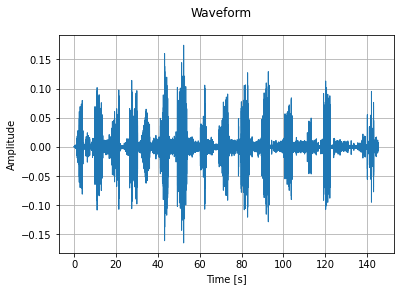

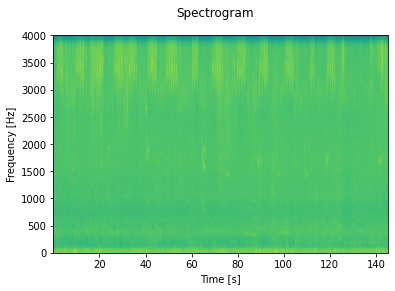

In [65]:
import torchaudio
import torch 
import matplotlib.pyplot as plt 

SAMPLE_MP3_PATH = ("/home/akinwilson/Projects/bird-sound-classifier/data/birds/Phylloscopuscollybita/Poland"
"/Phylloscopuscollybita325319.mp3")
metadata = torchaudio.info(SAMPLE_MP3_PATH)

def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()


def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].set_xlabel("Time [s]")
        axes[c].set_ylabel("Amplitude")
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
        
    figure.suptitle(title)
    plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()
    num_channels, _ = waveform.shape
    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate, sides="onesided")
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        axes[c].set_xlabel("Time [s]")
        axes[c].set_ylabel("Frequency [Hz]")
    figure.suptitle(title)
    plt.show(block=False)


def _get_sample(path, resample=None):
    effects = [["remix", "1"]]
    if resample:
        effects.extend(
            [
                ["lowpass", f"{resample // 2}"],
                ["rate", f"{resample}"],
            ]
        )
    return torchaudio.sox_effects.apply_effects_file(path, effects=effects)


def get_sample(SAMPLE_WAV_PATH, resample=None):
    return _get_sample(SAMPLE_WAV_PATH, resample=resample)


SAMPLE_RATE = 8000

waveform, sample_rate = get_sample(SAMPLE_MP3_PATH, resample=SAMPLE_RATE)
print("sampling rate", sample_rate)

print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)


In [120]:
MAX_TIME = 10
def align(torch_tensor,sampling_rate, MAX_TIME):
    if torch_tensor.shape[1] >  MAX_TIME * sample_rate:
        X =  torch_tensor[0,: MAX_TIME * sample_rate].unsqueeze(axis=0)
        assert X.shape == torch.Size([1, MAX_TIME * sample_rate]), f"miss match in return dim,\nexpected {torch.Size([1, MAX_TIME * sample_rate])},\n got {X.shape}"
        return X 

    elif torch_tensor.shape[1] <=  MAX_TIME * sample_rate:
        padding_num = MAX_TIME * sample_rate - torch_tensor.shape[1]
        X = torch.concat( (torch_tensor[0,:],torch.tensor([0]*padding_num) ) ).unsqueeze(axis=0)
        assert X.shape == torch.Size([1, MAX_TIME * sample_rate]), f"miss match in return dim,\nexpected {torch.Size([1, MAX_TIME * sample_rate])},\n got {X.shape}"
        return X 




align(waveform[0,:10].unsqueeze(dim=0), 8000, 10)
# torch.concat( (waveform[0,:80000],torch.tensor(

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])

The audio files need to be padded to the sample length. The sample rate varies across the files. We need to resample. 

(array([[5.91402032e-17, 1.46620631e-14, 2.58336022e-12, ...,
         1.14515982e-11, 1.76055207e-11, 3.99274178e-13],
        [3.03456752e-17, 9.57599249e-14, 3.82430994e-12, ...,
         5.15850337e-12, 1.29602384e-11, 5.91588351e-13],
        [3.07511426e-17, 1.29610617e-13, 2.60998890e-13, ...,
         2.23138800e-12, 5.98513005e-13, 2.05508084e-13],
        ...,
        [1.09051717e-19, 1.31538910e-18, 8.95730099e-18, ...,
         2.32696584e-16, 2.07188475e-16, 6.60965879e-19],
        [2.04086813e-19, 1.03302802e-19, 6.18422253e-19, ...,
         8.76913983e-17, 3.77190580e-20, 2.56728664e-18],
        [4.29772019e-24, 4.57116568e-20, 6.01465826e-20, ...,
         1.69761071e-18, 4.28781999e-19, 5.23497269e-19]]),
 array([   0.  ,   31.25,   62.5 ,   93.75,  125.  ,  156.25,  187.5 ,
         218.75,  250.  ,  281.25,  312.5 ,  343.75,  375.  ,  406.25,
         437.5 ,  468.75,  500.  ,  531.25,  562.5 ,  593.75,  625.  ,
         656.25,  687.5 ,  718.75,  750.  ,  781.25,

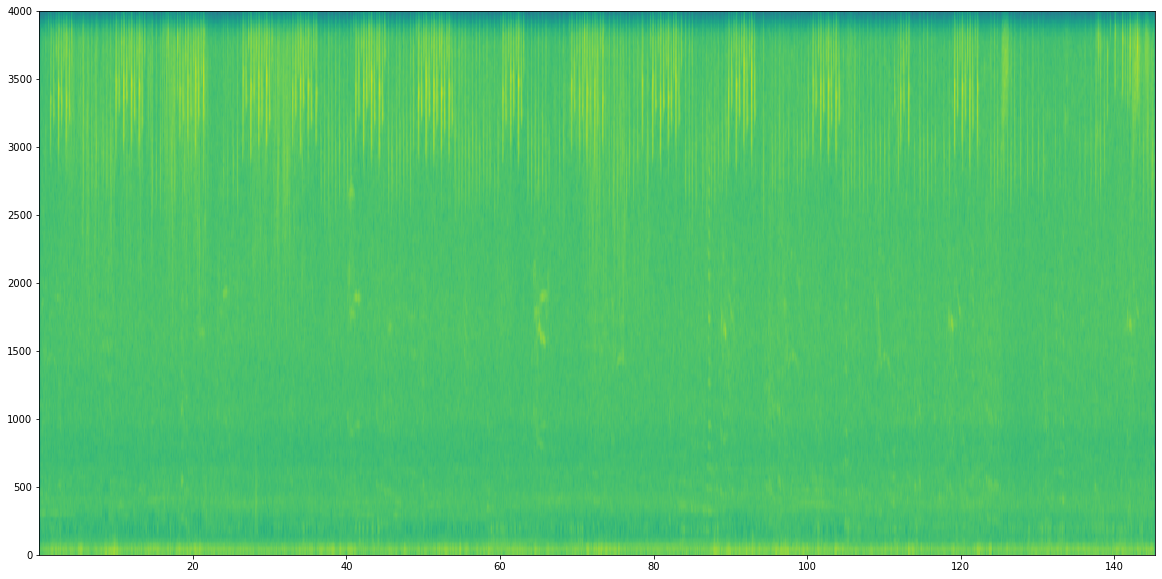

In [67]:
trans2spectrogram = torchaudio.transforms.Spectrogram(n_fft=256)
waveform, sample_rate = get_sample(SAMPLE_MP3_PATH, resample=SAMPLE_RATE)
spec = trans2spectrogram(waveform).log2()
# plot_specgram(spec, sample_rate=SAMPLE_RATE)
results = ax.specgram(waveform.numpy()[0], Fs=SAMPLE_RATE, sides="onesided")

torch.Size([1, 129, 9088])
mpl (129, 9086)
mpl (129,)


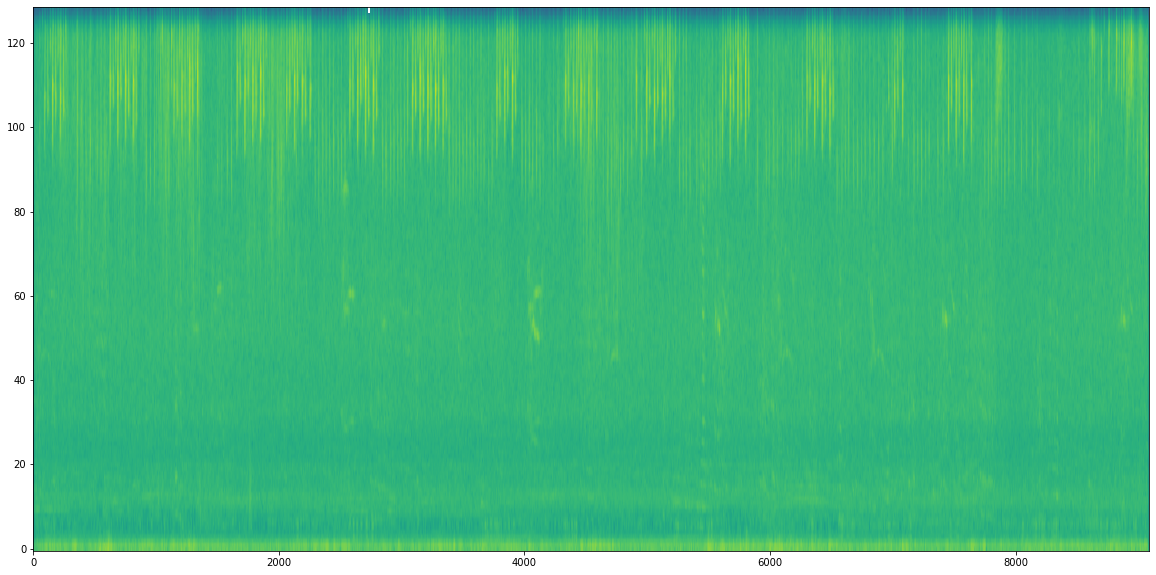

In [87]:
trans2spectrogram = torchaudio.transforms.Spectrogram(n_fft=256)
waveform, sample_rate = get_sample(SAMPLE_MP3_PATH, resample=SAMPLE_RATE)
spec = trans2spectrogram(waveform).log2()
print(spec.shape)
print("mpl", results[0].shape)
print("mpl", results[1].shape)
fig, ax = plt.subplots(1, 1,figsize=(20,10))
ax.imshow(spec.squeeze().numpy(), origin='lower', aspect='auto')

In [93]:
MAX_EPOCHS = 100
LR = 0.001


def spec2seq(spectogram):
    """
    Going to bucketise delta t vertical strips of the spectogram generated
    """
    return 


(3, 9088)

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from IPython.core.interactiveshell import InteractiveShell
import warnings 
import librosa
from sklearn.model_selection import train_test_split
import pandas as pd 
import pickle
import numpy as np
import glob 
import multiprocessing as mp  
import pydub 
# InteractiveShell.ast_node_interactive = "all"
warnings.filterwarnings("ignore")

In [ ]:
def get_file_paths():
    files = glob.glob("/home/akinwilson/Projects/bird-sound-classifier/data/birds/*/*/*")
    files = [f for f in files if f.endswith(".mp3")]
    return files
def test_load_audio(f):
    try:
        pydub.AudioSegment.from_mp3(f)
        return f
    except:
        pass 

In [ ]:
get_file_paths()

In [ ]:
def get_label_and_path(file_path):
    parts = tf.strings.split(input=file_path,sep=os.path.sep)
    return (file_path,parts[-3].numpy().decode("utf-8"))

def create_clean_ds():
    files = get_file_paths()
    pool = mp.Pool(mp.cpu_count()-2)
    files_clean = pool.map(test_load_audio,files )
    files_clean = [f for f in files_clean if f is not None]
    x = dict([get_label_and_path(f) for f in files_clean])
    pickle.dump(file=open("./data/total.p","wb"), obj=x)


    

# Data splitting

In [ ]:
def get_dataset(name):
    df = pd.DataFrame.from_dict(pickle.load(open(f"./data/{name}.p", "rb")).items())
    return df 

def create_train_test_split(df):
    return train_test_split( df[0], df[1], test_size=0.33, random_state=42)

Xtrain, Xtest, Ytrain, Ytest =  create_train_test_split(get_dataset("total"))

def save_train_test(data_dict, name):
    pickle.dump(data_dict, open(f"./data/{name}", "wb"))

# train = dict(zip(Xtrain, Ytrain))
# test = dict(zip(Xtest, Ytest))
# save_train_test(train, "train.p")
# save_train_test(test,"test.p")

In [ ]:
import torch 

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)

    

In [ ]:
import numpy as np  
import math
import scipy.io as sio

loadable_files = []
for f in files:
    try:
        pydub.AudioSegment.from_mp3(f)
        loadable_files.append(f)
    except:
        print(f"Except: {f}")

# audio.rate * 30 
# x = trim(stero2mono(audio))

def repeat_or_trim_audio(file_path):
    audio =  get_audio(file_path)
    x = trim(stero2mono(audio))

    SAMPLE_LEN = audio.rate  * 30  
    to_repeat = np.ceil(( SAMPLE_LEN / x.shape[0] ).numpy())
    
    if to_repeat == 1.0:
        print("trimmed")
        return x[:SAMPLE_LEN]
    elif not math.isinf(to_repeat) and to_repeat > 1.0:

        print("extended ")
        print("Keep upto: ", SAMPLE_LEN, "len")
        print("to_repeat:", to_repeat)
        print("current dim", x.shape)
        print("repeated len", tf.repeat(x, to_repeat, axis=0).shape)
        return tf.repeat(x, to_repeat, axis=0)[:SAMPLE_LEN]
    else:
        return 

In [ ]:
loss_history = []
for epoch in range(MAX_EPOCHS):
    loss = 0
    for i in range(len(X_train)):
        loss += model.loss(X_train[i], Y_train[i])
    loss = loss / len(X_train)
    print("Epoch {0} Loss {1}".format(epoch , loss))
    loss_history.append(loss)
    for i in range(len(X_train)):
       model.step(X_train[i], Y_train[i], learning_rate=LR)